In [1]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

In [2]:
class EnhancedStockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(EnhancedStockTradingEnv, self).__init__()

        self.df = df
        self.reward_range = (0, 1)
        
        # Assuming 'Symbols' represents different assets, and you might want to trade multiple assets
        # Adjust according to your exact dataset and requirements
        self.n_assets = len(df['Symbols'].unique())
        
        # Action space: [sell(0), hold(1), buy(2)] for each asset
        self.action_space = spaces.MultiDiscrete([3] * self.n_assets)
        
        # Observation space: Include all features for each asset
        self.feature_names = ['Open', 'Adj Close', 'High', 'Low', 'Volume', 'RSI', 'MACD', 'post utility']
        self.n_features = len(self.feature_names)
        
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets *
                                                                             self.n_features,), dtype=np.float32)
        
        self.current_step = 0
        self.done = False

        self.initial_account_balance = 1000000
        self.current_account_balance = self.initial_account_balance
        self.positions = np.zeros(self.n_assets)
        self.total_profit = 0

    def _next_observation(self):
        obs = np.zeros(self.n_assets * self.n_features)
        for i, symbol in enumerate(self.df['Symbols'].unique()):
            # Filter df by symbol and step
            symbol_df = self.df[self.df['Symbols'] == symbol].reset_index(drop=True)
            if self.current_step < len(symbol_df):
                step_data = symbol_df.loc[self.current_step, self.feature_names]
                obs[i*self.n_features:(i+1)*self.n_features] = step_data.values
        return obs

    def step(self, action):
        prev_total_value = self._calculate_total_portfolio_value()
        self.done = self.current_step >= (len(self.df) // self.n_assets) - 1
        current_prices = self._get_current_prices()

        transaction_cost = 0.001  # transaction cost: 0.1%
        investment_fraction = 0.1  # Example: use 10% of current balance for each buy action

        for i, act in enumerate(action):
            # Current price of the asset
            current_price = current_prices[i]

            if act == 0:  # Sell
                if self.positions[i] > 0:  # Check if we hold the asset
                    # Update account balance, consider transaction costs
                    self.current_account_balance += (1 - transaction_cost) * current_price * self.positions[i]
                    self.positions[i] = 0
            elif act == 2 and current_price > 0:
                # Calculate max possible shares to buy with the allocated fraction of the balance
                allocated_balance = self.current_account_balance * investment_fraction
                max_shares = allocated_balance / (current_price * (1 + transaction_cost))
                shares_to_buy = max_shares  # Adjust this logic if needed
                self.current_account_balance -= shares_to_buy * current_price * (1 + transaction_cost)
                self.positions[i] += shares_to_buy

        self.current_step += 1

        # Update total profit based on the portfolio value change
        current_total_value = self._calculate_total_portfolio_value()
        self.total_profit += current_total_value - prev_total_value

        next_obs = self._next_observation()
        reward = self.total_profit  # Consider refining this based on your objective
        info = {'current_balance': self.current_account_balance, 'total_profit': self.total_profit}

        return next_obs, reward, self.done, info


    def _calculate_total_portfolio_value(self):
        """Calculate the total value of the portfolio: cash + assets"""
        current_prices = self._get_current_prices()
        assets_value = np.dot(self.positions, current_prices)
        total_value = self.current_account_balance + assets_value
        return total_value

    def _get_current_prices(self):
        """Get the current prices of assets"""
        current_prices = np.zeros(self.n_assets)
        for i, symbol in enumerate(self.df['Symbols'].unique()):
            # Filter df by symbol and step
            symbol_df = self.df[self.df['Symbols'] == symbol].reset_index(drop=True)
            if self.current_step < len(symbol_df):
                current_prices[i] = symbol_df.loc[self.current_step, 'Adj Close']
        return current_prices


    def reset(self):
        self.current_step = 0
        self.done = False
        self.positions = np.zeros(self.n_assets)
        self.current_account_balance = self.initial_account_balance
        self.total_profit = 0
        return self._next_observation()

    def render(self, mode='human', close=False):
        print(f'Step: {self.current_step}, Total Profit: {self.total_profit}')
        
    def reset_with_data(self, new_df):
        # Method to reset the environment with new data
        self.df = new_df
        self.reset()

In [3]:
df = pd.read_csv('stocks_data/stocks_panel_data_with_utlity.csv', index_col=0)
df = df.fillna(0)

In [4]:
df.sort_values('Date', inplace=True)
df.reset_index(inplace=True, drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df_train = df[df['Date']< pd.to_datetime('2023-12-24')]
df_test = df[df['Date']> pd.to_datetime('2023-12-24')]
df_test

,Open,Adj Close,High,Low,Volume,Date,RSI,MACD,Symbols,post utility
14582,71.02,70.0500,71.5000,70.0200,10070960.0,2023-12-25,62.104584,0.715040,ALRS,-13.127682
14583,567.80,563.0000,572.4000,558.2000,1170939.0,2023-12-25,37.909320,-13.510864,VKCO,-26.187349
14584,358.50,360.3500,366.8000,358.5000,1859590.0,2023-12-25,56.549268,5.544408,MTLRP,-4.431373
14585,690.00,688.0000,699.0000,682.0000,38876.0,2023-12-25,57.819905,-9.714975,LENT,-1.318058
14586,17074.00,17130.0000,17186.0000,16920.0000,224046.0,2023-12-25,57.348963,24.678447,GMKN,-200.348295
...,...,...,...,...,...,...,...,...,...,...
16145,14600.00,14588.0000,14620.0000,14486.0000,45541.0,2024-03-01,22.857143,-412.945273,GMKN,-22.200323
16146,292.00,294.0400,294.1400,292.0000,1303930.0,2024-03-01,68.296089,3.955358,SBERP,-36.096699
16147,0.76,0.7593,0.7641,0.7575,91718000.0,2024-03-01,47.870968,-0.003215,HYDR,-10.547563
16148,718.80,718.6000,722.2000,714.2000,952063.0,2024-03-01,54.596888,3.460087,TATN,-16.505329


In [5]:
env = EnhancedStockTradingEnv(df_train)

model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/gosa/Desktop/conda/miniconda3/envs/myenv/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [6]:
model.learn(total_timesteps=100000)

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 428       |
|    ep_rew_mean     | -1.65e+07 |
| time/              |           |
|    fps             | 11        |
|    iterations      | 1         |
|    time_elapsed    | 182       |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 428          |
|    ep_rew_mean          | -2.29e+07    |
| time/                   |              |
|    fps                  | 11           |
|    iterations           | 2            |
|    time_elapsed         | 364          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 1.375447e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -37.4        |
|    explained_variance   | 5.96e-08     |
|    

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 428           |
|    ep_rew_mean          | -2.58e+07     |
| time/                   |               |
|    fps                  | 11            |
|    iterations           | 11            |
|    time_elapsed         | 2018          |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 1.3562385e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -37.4         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 2.59e+12      |
|    n_updates            | 100           |
|    policy_gradient_loss | -2.11e-05     |
|    value_loss           | 5.58e+12      |
-------------------------------------------
------------------------------------------
| rollout/                |      

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 428           |
|    ep_rew_mean          | -2.77e+07     |
| time/                   |               |
|    fps                  | 6             |
|    iterations           | 20            |
|    time_elapsed         | 6650          |
|    total_timesteps      | 40960         |
| train/                  |               |
|    approx_kl            | 1.5861588e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -37.4         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 3.29e+12      |
|    n_updates            | 190           |
|    policy_gradient_loss | -1.75e-05     |
|    value_loss           | 6.14e+12      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 428          |
|    ep_rew_mean          | -2.7e+07     |
| time/                   |              |
|    fps                  | 6            |
|    iterations           | 29           |
|    time_elapsed         | 9128         |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 3.684545e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -37.4        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 2.02e+12     |
|    n_updates            | 280          |
|    policy_gradient_loss | -2.62e-05    |
|    value_loss           | 3.75e+12     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 428           |
|    ep_rew_mean          | -2.42e+07     |
| time/                   |               |
|    fps                  | 4             |
|    iterations           | 38            |
|    time_elapsed         | 15976         |
|    total_timesteps      | 77824         |
| train/                  |               |
|    approx_kl            | 2.3661414e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -37.4         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 3.61e+12      |
|    n_updates            | 370           |
|    policy_gradient_loss | -2.16e-05     |
|    value_loss           | 6.55e+12      |
-------------------------------------------
------------------------------------------
| rollout/                |      

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 428           |
|    ep_rew_mean          | -2.57e+07     |
| time/                   |               |
|    fps                  | 2             |
|    iterations           | 47            |
|    time_elapsed         | 33078         |
|    total_timesteps      | 96256         |
| train/                  |               |
|    approx_kl            | 1.7811544e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -37.4         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0001        |
|    loss                 | 2.7e+12       |
|    n_updates            | 460           |
|    policy_gradient_loss | -2.1e-05      |
|    value_loss           | 5.45e+12      |
-------------------------------------------
------------------------------------------
| rollout/                |      

In [7]:
env.reset_with_data(df_test)
portfolio_values = [1000000]
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    portfolio_values.append(env._calculate_total_portfolio_value())

initial_portfolio_value = portfolio_values[0]
pnl = [((pv - initial_portfolio_value) / initial_portfolio_value) * 100 for pv in portfolio_values] 

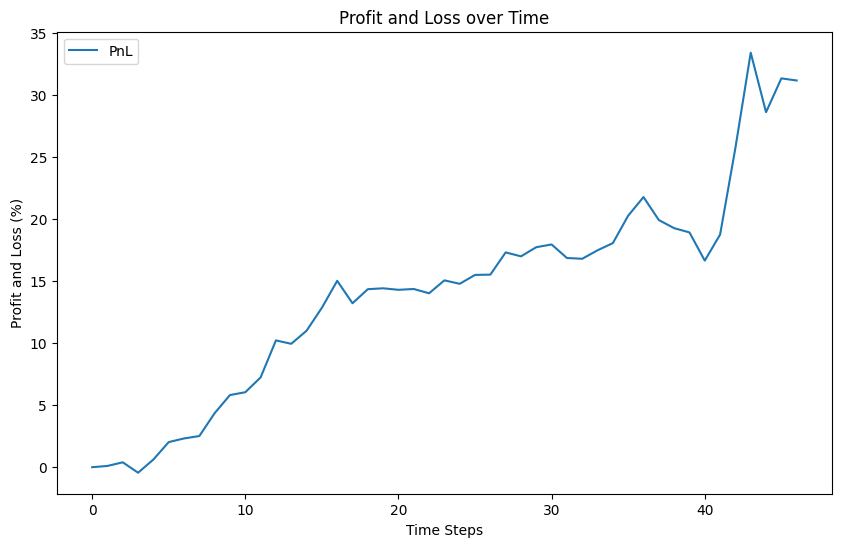

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(pnl, label="PnL")
plt.xlabel("Time Steps")
plt.ylabel("Profit and Loss (%)")
plt.title("Profit and Loss over Time")
plt.legend()
plt.show()

In [14]:
# Calculate daily returns
returns = np.diff(portfolio_values) / portfolio_values[:-1]

# Compute Sharpe ratio
mean_return = np.mean(returns)
std_return = np.std(returns)
sharpe_ratio = (mean_return) / std_return if std_return != 0 else 0

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 0.37


In [13]:
mean_return*np.sqrt(252)

0.09596857112763979